# <span style="color:green"> Run on python 3.6</span>

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

ПРОТЕСТИТЬ, ЧТОБЫ ОДИН ГПР ИЛИ ОДНА СЕТКА МОГЛИ ЗАФТИТИТЬ ЗАВИСИМОСТЬ ДЛЯ ОДНОЙ КОМПОНЕНТЫ

- Матрица X - это не вектора V, на которые мы проектируем силы, X должна быть ранга 1

In [1]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
import gc
import torchvision.transforms as transforms

from itertools import islice
from collections import defaultdict
import csv

from utility_funcs import *
from LJ_modeling_realization.includes.constants import *

- Проблема с двумя частицами в том, что у них абсолютно одинаковые матрицы X, но разные перемещения, но почему у них одинаковые матрицы......
- потестить если юзать только одну частицу для обучения

# ПЕРЕМЕЩЕНИЯ СМОТРИМ НА АНФОЛДЕД КООРДИНАТАХ, МАТРИЦУ СЧИТАЕМ НА ФОЛДЕД - ЗДЕСЬ ПОКА ЭТО НЕ СДЕЛАНО

In [2]:
MODE

'movements'

In [3]:
if CFG.N != N:
    Exception("N != CFG.N")

In [4]:
naming_of_target_in_csv = naming_of_target_in_csv[MODE]

In [5]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

---

# Hyperparameters:

In [6]:
f'p: {CFG.p}, r_cut: {CFG.r_cut}'

'p: [1.33748274 1.10664655 1.19813929 1.30340941 2.46883468 1.32919421\n 2.63312177 1.9995623  1.984318   2.22623307], r_cut: [9.75684441 5.93417153 5.89382818 8.77167283 5.85468936 6.74634692\n 8.95713186 5.11623939 6.48025165 6.28477542]'

---

## Код для создания моих csv файлов из .xyz или .force

Используя np.reshape() можно 1d array превращать в матрицу просто

**Create csv_from_force - функция, которая создает цсв-хи с которыми я работаю из LAMMPS-овского аутпута**

In [7]:
# read_path = f'high_T1_{CFG.N}particle.force'
read_path = None

lines_read_coef = 1500

# Создаем цсвшки для координат и силы:
try:
    create_csv_from_force(
        write_folder="coords_and_forces",

        # read_path='high_T.force',
        read_path=read_path,

        use_particles=2,

        recalculate_forces=True if MODE == "forces" else False,
        # step = 1,
        lines_read_coef=lines_read_coef,
    )
except:
    print(
        f"NO FILE FOR {CFG.N} PARTICLES TO CREATE CSV FROM"
    )

use_particles is not None - forces will be recalculated anyway
NO FILE FOR 50 PARTICLES TO CREATE CSV FROM


In [8]:
# velocity_path = read_path.split(".")[0] + ".velocity" if MODE == "movements" else None
velocity_path = None

#Создаем цсвшки для скоростей:
try:
    if velocity_path:
        create_csv_from_force(
        write_folder="coords_and_forces",        # СОХРАНЯЕМ ЦСВШКУ ДЛЯ СКОРОСТЕЙ ИМЕННО К СИЛАМ, ПОТОМУ ЧТО МЫ ДОЛЖНЫ ДРОПНУТЬ ПОСЛЕДНЮЮ СТРОЧКУ И ЕЩЕ СДЕЛАТЬ STEP - ЭТО ДЕЛАЕТСЯ КАК РАЗ ВНУТРИ ФУНКЦИИ СОЗДАНИЯ MOVEMENTS.CSV

        # read_path='high_T.force',
        read_path=velocity_path,

        use_particles=CFG.N,
        recalculate_forces=False if MODE=="movements" else True,      # СУПЕР ВАЖНО - ПОТОМУ ЧТО СКОРОСТИ ТАМ КАК СИЛЫ ВОСПРИНИМАЮТСЯ В КОДЕ...,

        velocity_regime=True,
        # step = 1,
        lines_read_coef=lines_read_coef,
        )

except:
    print(
        f"NO FILE FOR {CFG.N} PARTICLES TO CREATE CSV FROM"
    )

---

In [9]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)
    forces = pd.read_csv(forces_file_path)

    # print(len(coords), len(forces))

    # print(
    #     pd.concat([coords, forces], axis=1).notna().sum()
    # )

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    # return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')
    # return coords.join(forces.set_index("t"), on="t")
    return pd.concat([coords, forces], axis=1)

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [10]:
def _get_relative_positions(row, atom_number, naming_of_target_in_csv=naming_of_target_in_csv):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in naming_of_target_in_csv:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    # print('rel_dists: ', Rel_matrix)

    return np.array(Rel_matrix), np.array(force_vec)

In [11]:
from sklearn.preprocessing import normalize

In [12]:
def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [13]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K, use_orthogonal=False, use_A_t=True):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if use_orthogonal and CFG.K == 3:
        diagonal_V_matr = [[0] * CFG.K for i in range(K)]
        for i in range(K):
            diagonal_V_matr[i][i] = V[i][i]
        V = np.array(
            diagonal_V_matr
        )

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    # print(V, A)

    if use_A_t:
        X = V @ A.T
    else:
        X = V

    return X, A

In [14]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig, use_orthogonal=True, use_A_t=True, naming_of_target_in_csv=naming_of_target_in_csv):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number, naming_of_target_in_csv=naming_of_target_in_csv)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig, use_orthogonal=use_orthogonal, use_A_t=use_A_t)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [15]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold, f_min_threshold=CFG.f_min_threshold,
            naming_of_target_in_csv=naming_of_target_in_csv):
    '''

    Убирает строчки с аномально большими силами из df

    Также убирает нижни силы, меньше f_min_threshold

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in naming_of_target_in_csv:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) < f_min_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [16]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.pinv(A)

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_path = 'coords.csv', forces_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    clean=True,
    use_orthogonal=False,
    use_A_t=True,
    path_to_vel=None,
    
    use_vel=True,
    
    naming_of_target_in_csv=naming_of_target_in_csv,

    atoms_to_use=range(CFG.N)
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    use_A_t: Использовать ли X = VA^T или X=V (при k!= 3 матрица будет не квадратной)

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_path, forces_file_path=forces_path)
    if length:
        df = df.loc[range(length)]

    # чистка df от больших сил
    if clean:
        df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    if MODE == "movements" and use_vel:
        if path_to_vel:
            df_vels = pd.read_csv(path_to_vel, index_col=False)
        else:
            df_vels = pd.read_csv("./coords_and_movements/" + f'velocities{CFG.N}.csv', index_col=False)

    row_indexes = [idx for i, idx in enumerate(df.index) if i % step == 0]

    for atom_number in atoms_to_use:
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number, use_orthogonal=use_orthogonal, use_A_t=use_A_t, naming_of_target_in_csv=naming_of_target_in_csv)
            if transform:
                x = transform(x)
            else:
                x = torch.tensor(x)
            x = x.to(torch.float)
            # print(x)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)
            flat_x = torch.flatten(x)

            if MODE == "movements" and use_vel:
                row_vels = df_vels.iloc[index]
                columns_to_get_vels_from = [str(atom_number) + elem for elem in ["v_x", "v_y", "v_z"]]
                vel_vec = torch.tensor(row_vels[columns_to_get_vels_from])

                k_dim_v = get_projections(vec_to_project=vel_vec.numpy(), mat_of_directions=A)
                flat_x = torch.cat([flat_x, torch.tensor(k_dim_v)])

            dataset.append(
                (flat_x.to(torch.float), torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [17]:
folder = "coords_and_" + MODE   # MODE справа

coords_file_path = folder + '/coords' + str(CFG.N) + '.csv'
forces_file_path = folder + '/' + MODE + str(CFG.N) + '.csv'    # и здесь тоже MODE вместо forces
velocities_file_path = folder + '/' + 'velocities' + str(CFG.N) + '.csv'
d_velocities_file_path = folder + '/' + 'd_velocities' + str(CFG.N) + '.csv'

**В файлах которые я пилю руками на своем коде - там запись в файлы не с начала движения может быть**

In [18]:
movements_step = 1

# movements.csv are created based on coords.csv in forces and then coords.csv gets cut and saved in movements folder and we get syncronized by amount of rows csv files

# So create movements.csv now does not cut velocity.csv
if MODE == "movements":
    create_movements_csv(
        #TODO: make create_movements.csv also cut default velocity file and save its cut version into movements folder
        CFG.N,
        step=movements_step,

        coords_path_to_get_movements_from=f'./LJ_modeling_realization/coords{CFG.N}.csv',
        path_to_get_velocities_from=f'./LJ_modeling_realization/velocities{CFG.N}.csv',

        create_d_velocity=True
    )

Трабла с тем, что делим на нуль, если по одной оси одинаковая координата и мы делаем use_orthogonal

In [19]:
# df = create_df_with_coords(coords_file_path, forces_file_path)
# row = df.iloc[0]

# get_matrix_for_atom(row, 0)

In [20]:
dataset_step = 10
atoms_to_use = [0, 1]
atoms_to_use = list([i for i in range(CFG.N)])

dataset = create_tensor_dataset(
    coords_path=coords_file_path,
    forces_path=forces_file_path,

    path_to_vel=velocities_file_path,
    # use_vel=False,

    step=dataset_step,

    clean=False,
    use_orthogonal=True,     # оно может сработать только для K=3, так как матрица V размера K x 3

    use_A_t=True,
    # use_A_t=False
    atoms_to_use=atoms_to_use
)

Progress for atom 49: 100%|██████████| 250/250 [00:16<00:00, 15.34it/s]


In [21]:
dataset_folder = "dataset_objects/" + MODE + '/'
torch.save(dataset, dataset_folder + str(CFG.N) + '_dataset_K_' + str(CFG.K) + '.pt')

**Распределение для первого элемента матрицы:**

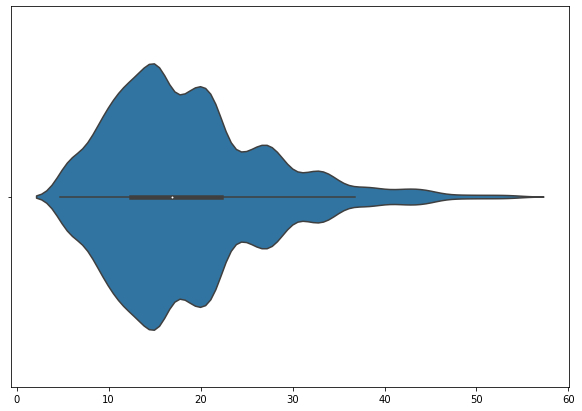

In [22]:
plt.figure(figsize=(10, 7))
sns.violinplot(
    x=[elem[0][0].item() for elem in dataset], width=0.7
)
None

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
dataset1 = dataset.copy()

In [25]:
# dataset = dataset1[:1000]

**Отрисовать Верле и отрисовать само трушное:**

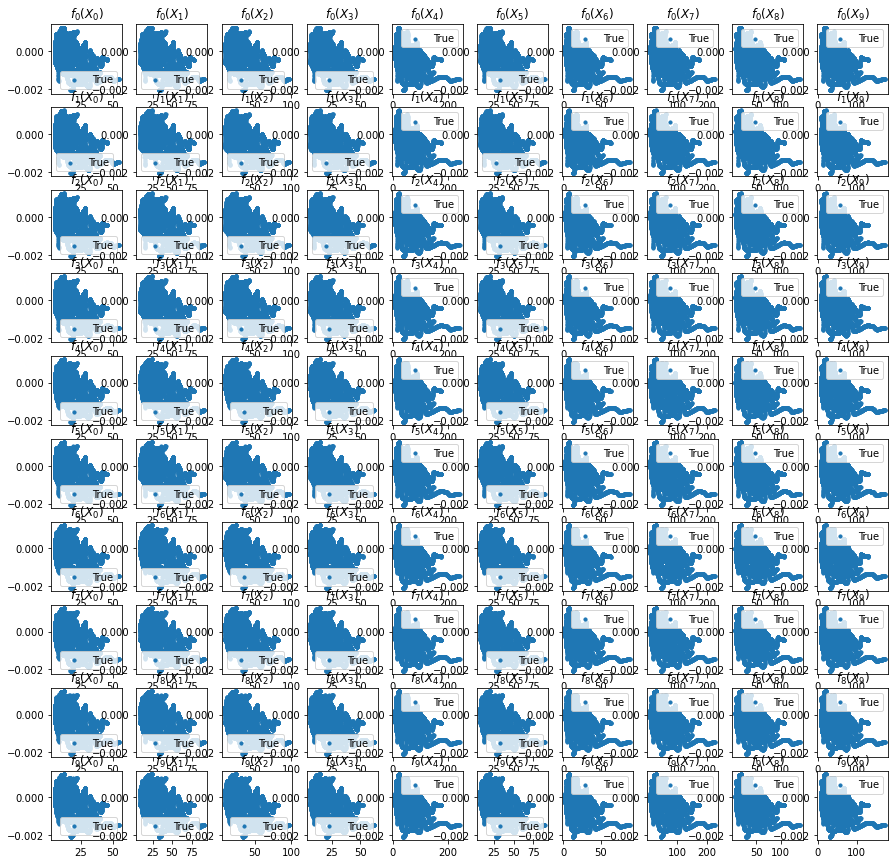

In [26]:
X = (torch.stack([elem[0] for elem in dataset]))
x11 = X[:, 0]
x22 = X[:, 4]
x33 = X[:, 8]

Y_true = torch.stack([elem[1] for elem in dataset])

# plot_2d_result(
#     x11,
#     y_true=Y_true if len(dataset[0][1]) == 1 else Y_true[:, 0],
#     figsize=(10, 7)
# )

plot_matrix(X=X[:, :CFG.K * CFG.K], Y_true=Y_true, K=CFG.K)

$$
X = V A^T
$$
Если все элементы матрицы V одинаковые, то матрица A имеет вид

**У нас все-таки перемещения и у них проекции не равны будут в векторе перемещений даже если все V_i совпадают**

Виды изменения матрицы X:

- K=3:
    - делать матрицу V вида: diag(V[0][0], V[1][1], V2][2]); позволяет избежать близости векторов внутри V за счет чего получаем более далекие значения а еще матрица pinv_a тогда не сингулярная - теряется симметрия относительно вращений (а может и нет кстати)

    - делать X = V вместо AV^T - так мы обучаемся прямо на модельных "силах" и знак так не съедается (мб стоит попробовать sgn добавить чтобы знак не хавался) - теряется симметрия относительно вращений

# Для модели для предсказания скоростей по тем же фичам:

In [27]:
def create_dataset_object_for_d_velocities(atoms_to_use, step=dataset_step, coords_path=coords_file_path, velocities_path=velocities_file_path, d_velocities_path=d_velocities_file_path):
    '''
    creates.pt for velocities: it will be a dataset object, which will be the same dataset as for movements/forces, but with dv instead of ds or f
    '''

    dataset = create_tensor_dataset(
        step=step,

        coords_path=coords_path,
        forces_path=d_velocities_path,

        path_to_vel=velocities_path,
        # use_vel=False,

        clean=False,
        use_orthogonal=True,     # оно может сработать только для K=3, так как матрица V размера K x 3

        use_A_t=True,
        
        atoms_to_use=atoms_to_use,

        naming_of_target_in_csv=["dv_x", "dv_y", "dv_z"]
        # use_A_t=False
    )
    dataset_folder = "dataset_objects/" + "d_velocities" + '/'
    torch.save(dataset, dataset_folder + str(CFG.N) + '_dataset_K_' + str(CFG.K) + '.pt')

    return dataset

Делаем так: При создании movements у нас создаются файлы для скоростей и для координат внутри coords_and_movements

In [28]:
vel_dataset = create_dataset_object_for_d_velocities(
    atoms_to_use=atoms_to_use
)
None

Progress for atom 49: 100%|██████████| 250/250 [00:16<00:00, 15.50it/s]


In [29]:
vel_dataset[0]

(tensor([19.1158, 19.1157, 19.1158, 19.1158, 19.1114, 19.1158, 19.1100, 19.1143,
         19.1144, 19.1131, 36.7019, 36.7023, 36.7022, 36.7020, 36.6900, 36.7019,
         36.6868, 36.6971, 36.6973, 36.6940, 37.1755, 37.1756, 37.1756, 37.1756,
         37.1648, 37.1755, 37.1617, 37.1714, 37.1716, 37.1686, 22.2893, 22.2891,
         22.2892, 22.2893, 22.2838, 22.2893, 22.2821, 22.2874, 22.2874, 22.2859,
         42.7986, 42.7943, 42.7961, 42.7980, 42.8086, 42.7985, 42.8084, 42.8068,
         42.8067, 42.8081, 31.3293, 31.3290, 31.3292, 31.3293, 31.3219, 31.3293,
         31.3195, 31.3268, 31.3269, 31.3247, 14.3029, 14.3013, 14.3019, 14.3027,
         14.3072, 14.3028, 14.3073, 14.3062, 14.3062, 14.3068, 52.7970, 52.7937,
         52.7952, 52.7966, 52.7990, 52.7969, 52.7972, 52.8012, 52.8012, 52.8007,
         32.9071, 32.9051, 32.9059, 32.9068, 32.9081, 32.9070, 32.9069, 32.9095,
         32.9095, 32.9092, 35.3892, 35.3863, 35.3875, 35.3888, 35.3938, 35.3891,
         35.3931, 35.3939, 3

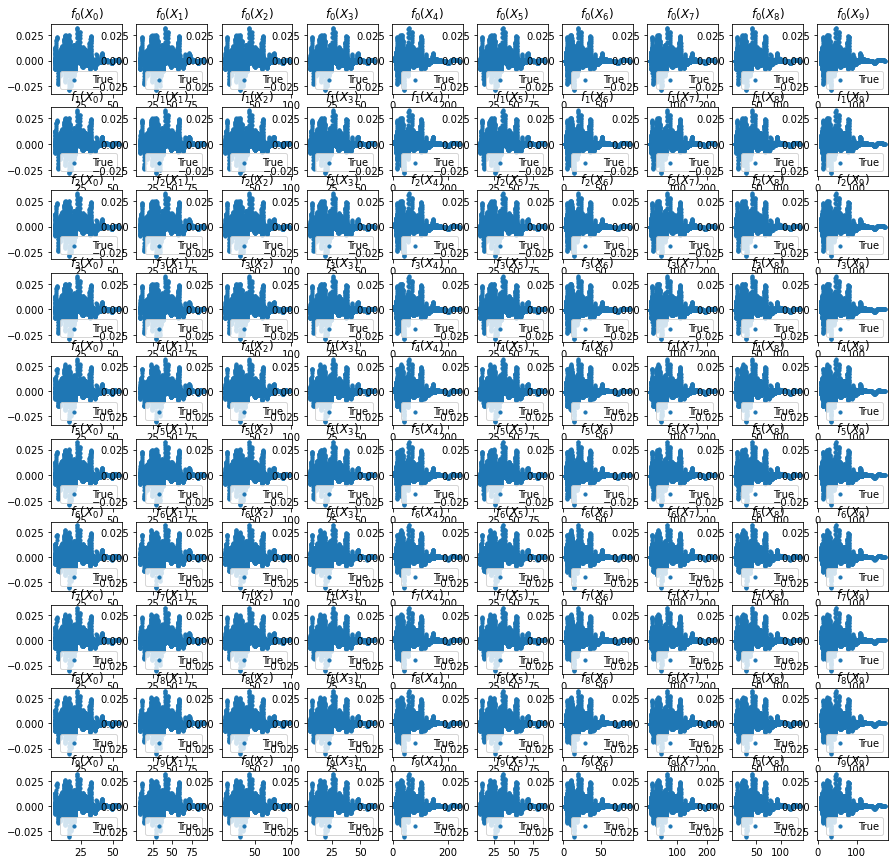

In [30]:
X_vel = (torch.stack([elem[0] for elem in vel_dataset]))
x11 = X_vel[:, 0]
x22 = X_vel[:, 4]
x33 = X_vel[:, 8]

Y_true = torch.stack([elem[1] for elem in vel_dataset])

# plot_2d_result(
#     x11,
#     y_true=Y_true if len(dataset[0][1]) == 1 else Y_true[:, 0],
#     figsize=(10, 7)
# )

plot_matrix(X=X_vel[:, :CFG.K * CFG.K], Y_true=Y_true, K=CFG.K)

---
---
---

---
---
---